# Lab 7

**Lecture**: Deep Learning (Prof. Dr. David Rügamer, Emanuel Sommer)

Welcome to the seventh lab, which is focused on convolutions and convolutional neural
networks. The first exercise shows how to train CNNs with Pytorch, while the second
exercise is about implementing convolutions for black-and-white images.
The third exercise is about computing the gradients of the convolution operator.

## Imports

In [1]:
from io import BytesIO
from math import ceil

import matplotlib.pyplot as plt
import requests
import torch
import torch.nn.functional as F
from PIL import Image
from matplotlib_inline.backend_inline import set_matplotlib_formats
from torch import nn, Tensor
from torch.optim import RMSprop
from torch.utils.data import DataLoader
from torchsummary import summary
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid

set_matplotlib_formats('png', 'pdf')

## Exercise 1
In this exercise, we will learn how to build CNNs in PyTorch to classify images.

CNNs are a special type of neural network inspired by the structure of the visual
cortex in animals. They can be applied to a wide range of tasks such as image recognition,
time-series analysis, sentence classification, etc. Two key features that differentiate
CNNs from fully connected nets are:

 1. Local connections: Each neuron in a convolutional layer is only connected to a
subset of the neurons in the previous layer.
 2. Shared weights: Each convolutional layer consists of multiple filters and each
filter consists of multiple neurons. All the neurons in a given filter share the same
weights but each of these neurons is connected to a different subset of the neurons in
the previous layer.

CNNs consistently outperform all other models in machine vision tasks such as image
recognition, object detection, etc.

### Classifying hand-written digits
We will be working with is the MNIST dataset (included in `torchvision`).
It consists of 28x28 pixels, grayscale images of hand-written digits and their
associated labels (0 to 9). The training set contains 60,000 images and the test set
contains 10,000.

The `torchvision` implementation of MNIST directly gives us a `Dataset` that we can
use for the `Dataloader`. However, in its plain form the dataset will return a PIL image
in which the elements take values between 0 and 255.
It is standard practice to scale the inputs so that the elements take values
between 0 and 1. This typically helps the network train better and we need a tensor
anyway.
This can be quickly done by specifying the `transform` argument with the `ToTensor`
transformation, which will convert the PIL images on the fly.
There are a lot of transformations available and they are arbitrarily composable to any
complexity. This is usually done in the context of data augmentation. You can check some
other transforms [here](https://pytorch.org/vision/stable/transforms.html).

In [2]:
train_dataset = MNIST(root='.data', train=True, download=True, transform=ToTensor());
test_dataset = MNIST(root='.data', train=False, download=True, transform=ToTensor());

Let's visualize a few images with the `make_grid` utility.
We need to permute the dimensions as tensors are of shape `channel x height x width` but
the matplotlib convention follows `height x width x channel`.

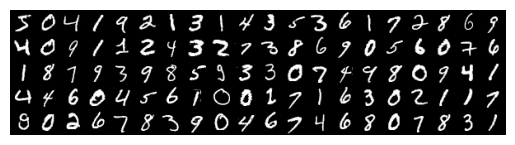

In [3]:
image_batch = torch.stack([train_dataset[i][0] for i in range(100)])
image_grid = make_grid(image_batch, nrow=20)
plt.imshow(image_grid.permute(1, 2, 0))
plt.axis('off')
plt.show()

### Build the network
A CNN typically consists of a series of convolutional and pooling layers followed
by a few fully-connected layers. The convolutional layers detect important
visual patterns in the input, and the fully-connected layers then classify the input
based on the activations in the final convolutional/pooling layer.
Each convolutional layer consists of multiple filters. When the CNN is trained,
each filter in a layer specializes in identifying patterns in the image that downstream
layers can use.

To create a convolutional layer in PyTorch, call the
[`Conv2D`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) module,
and specify the the number of filters in the layer (`in_channels` and 'out_channels'
parameter) and the size of the filters (`kernel_size` parameter).

Pooling layers are used to downsample intermediate feature maps in the CNN.
PyTorch has multiple options for pooling layers, but today we will only use
[`MaxPool2D`](https://pytorch.org/docs/stable/nn.html#pooling-layers) which takes a
`kernel_size` argument for the size of the pooling window.

In [4]:
model = nn.Sequential(
    nn.Conv2d(
        in_channels=1,
        out_channels=32,
        kernel_size=(3, 3),
    ),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2),
# TODO: Add following layers:
# 1. Convolution with 64 filters, 3 x 3 size and ReLU activation
# 2. Max pooling with window size of 2
# 3. Convolution with 64 filters, 3 x 3 size and ReLU activation
# 4. Flatten the data. Hint: Check nn.Flatten.
# 5. Add a fully connected layer with 576 input and 64 output features and ReLu
# 6. Add a fully connected output layer with 10 output features.
)

Now, we define the device that we would like to use for handling tensors.
Here, it will use the GPU for computation if it is available.

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Don't forget to send the model to the correct device!

In [6]:
# Push the model to the device.

Let's take a look at what we've built so far. The `summary` function from `torchsummary`
is able to visualize the created network a bit better.
We can also inspect the number of parameters and the memory consumption of a forward &
backward pass.

In [7]:
summary(model, input_size=(1, 28, 28), device=str(device))

You can see that the output of every `Conv2D` and `MaxPool2D` is a 3D tensor of shape
`(channels, height, width)`. For example, the output of the first layer is a tensor
of shape `(32, 26, 26)`. Note that the width and height dimensions shrink as you go
deeper in the network. The number of channels is controlled by the `filters` parameter
of the convolutional layers.

In the model we specified a 576-dimensional fully connected kind of as a magic number,
but now we can see why this is done.

After the 3 convolutional layers, the output tensor has a size of $64 \times 3 \times 3$.
As a linear layer only accepts a one dimensional input, we flatten the tensor and arrive
at $64 \cdot 3 \cdot 3 = 576$

### Train and evaluate the model

Similar as in the exercise before, we will define our training loop.
You may notice some differences:

- The dataloader now has a `num_workers` argument. This specifies the number of parallel
workers that will fetch data from the dataset. A typical heuristic is to set this parameter
to the total number of your CPU cores. This can be a critical bottleneck, when a lot of
stuff like augmentations is happening in the `__get_item__` method of your `Dataset`.
In our case we only apply the `ToTensor` transformation, so the overhead should be pretty
low.
- Our dataset is currently on the CPU by default. Thus, we still need to push the
`x` and `y` tensors from the dataloader to the correct device.
- We don't have any softmax function in our workflow. That's right! The cross entropy
loss of PyTorch works directly on the raw scores and so we can save unnecessary computations.
The predicted labels of the model can be obtained by applying `argmax` to the `y_hat`
tensor, which returns the index with the largest score.

In [8]:

# Set some constants
epochs = 5
batch_size = 64
num_workers = 4

max_batches = ceil(len(train_dataset) / batch_size)

loss = (
# Define the crossentropy loss function.
)

optimizer = (
# Define the RMSprop optimizer with the model parameters.
)


train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

for ep in range(1, epochs + 1):

    total_loss = 0
    num_correct = 0

    for batch_idx, (x, y) in enumerate(train_loader):

        # Push tensors to device
        x = x.to(device)
        y = y.to(device)

# TODO: Do a forward pass and compute the loss.
# TODO: Add backpropagation of the loss and apply the gradients via the optimizer.

        # Print progress every 10 batches
        if batch_idx % 10 == 0:
            print('BATCH:\t({:5} / {:5})\tLOSS:\t{:.3f}'
                  .format(batch_idx, max_batches, float(batch_loss) / batch_size), end='\r')

        total_loss += float(batch_loss)
        num_correct += int(torch.sum(torch.argmax(y_hat, dim=1) == y))

    print('EPOCH:\t{:5}\tLOSS:\t{:.3f}\tACCURACY:\t{:.3f}'
          .format(ep, total_loss / len(train_dataset), num_correct / len(train_dataset),
                  end='\r'))

After we trained the model, we evaluate it on the test dataset.

In [9]:

# We can choose a much larger batch size,
# as we don't need to compute any gradients and only do inference.
test_loader = DataLoader(
    dataset=train_dataset,
    batch_size=1024,
    num_workers=4,
)

total_loss = 0
num_correct = 0

for batch_idx, (x, y) in enumerate(train_loader):
    # Push tensors to device
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
# TODO: Do a forward pass and get the batch loss

    total_loss += float(batch_loss)
    num_correct += int(torch.sum(torch.argmax(y_hat, dim=1) == y))

print('EVALUATION LOSS:\t{:.3f}\tEVALUATION: ACCURACY:\t{:.3f}'
          .format(total_loss / len(train_dataset), num_correct / len(train_dataset),
                  end='\r'))

The accuracy of our model on MNIST is quite good!

## Exercise 2
In this exercise we are going to implement convolution on images, without worrying
about stride and padding, and test it with the Sobel filter. There are two Sobel filters:
$G_x$ detects horizontal edges and $G_y$ detects vertical edges.

\begin{equation}
G_x=\begin{vmatrix}
-1 & 0 & 1 \\
-2 & 0 & 2 \\
-1 & 0 & 1
\end{vmatrix}
\qquad
G_y=\begin{vmatrix}
-1 & -2 & -1 \\
0 & 0 & 0 \\
1 & 2 & 1
\end{vmatrix}={G_x}^T
\end{equation}

Can you explain why and how these filters work?

In order to get the image $E$ with the edges, we convolve $G_x$ and $G_y$ with the input
 image $I$, to obtain the degree of horizontal and vertical "borderness" of each pixel.
 We then combine these values (separately for each pixel) with an L2 norm:

\begin{equation}
E=\sqrt{(G_x*I)^2+(G_y*I)^2}
\end{equation}

Let's load an example image:

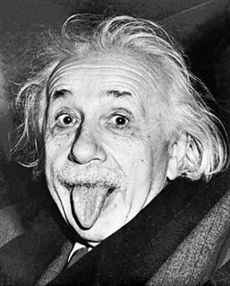

In [10]:
url = 'https://upload.wikimedia.org/wikipedia/en/8/86/Einstein_tongue.jpg'
response = requests.get(url)
img_raw = Image.open(BytesIO(response.content))

img_raw

We will further use this image as a tensor and drop the channel dimension.

In [11]:
img = ToTensor()(img_raw)[0]
print(img.shape)

torch.Size([286, 230])


As a reference, this is the result we want to obtain:

torch.Size([284, 228])


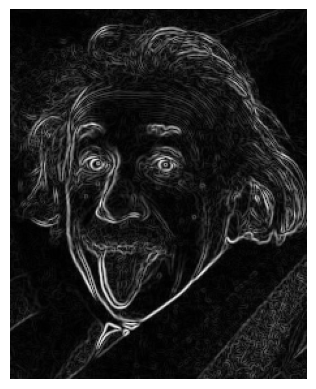

In [12]:
def apply_sobel(img: Tensor) -> Tensor:
    # Define the two filters
    sobel_x = torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
        dtype=torch.float)

    sobel_y = torch.tensor([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]],
        dtype=torch.float)

    # We can use the functional API of torch to perform the convolution manually
    conv_x = F.conv2d(img.unsqueeze(0).unsqueeze(0), sobel_x.view(1, 1, 3, 3))
    conv_y = F.conv2d(img.unsqueeze(0).unsqueeze(0), sobel_y.view(1, 1, 3, 3))

    # Combine the two convolutions
    conv = torch.sqrt(conv_x**2 + conv_y**2)

    # Normalize maximum value to 1
    return (conv / torch.max(conv)).squeeze(0).squeeze(0)

img_sobel = apply_sobel(img)
print(img_sobel.shape)
plt.imshow(img_sobel, cmap='gray')
plt.axis('off')
plt.show()

We now implement our version of convolutions. For an input matrix $\textbf{X}$ of size
$r(\textbf{X})\times c(\textbf{X})$ and a kernel $\textbf{K}$ of size
$r(\textbf{K})\times c(\textbf{K})$, the result of the convolution is
$\textbf{Y}=\textbf{K}*\textbf{X}$ with $r(\textbf{Y})=r(\textbf{X})-r(\textbf{K})+1$,
$c(\textbf{Y})=c(\textbf{X})-c(\textbf{K})+1$, and elements:

\begin{equation}
y_{ij}=\sum_{k=1}^{r(\textbf{K})}\sum_{l=1}^{c(\textbf{K})}x_{i+k-1,j+l-1}\cdot k_{kl}
\end{equation}

for $1\leq i \leq r(\textbf{Y})$ and $1\leq j \leq c(\textbf{Y})$.

You now have to implement a function that computes $y_{ij}$ given the image, the kernel, $i$ and $j$.

In [13]:

def compute_convolution_at_position(i: int, j: int, img: Tensor, kernel: Tensor) -> Tensor:
# TODO: Compute and return the convolution at `y_ij` with the formula above


def apply_convolution(img: Tensor, kernel:Tensor) -> Tensor:
    height, width = img.shape
    img_out = torch.zeros(height - 2, width - 2)

# TODO: Compute the convoluted value for every y_ij in the image.
# Note: Watch the index bounds of the image!

    return img_out

def apply_custom_sobel(img: Tensor) -> Tensor:
    # Define the two filters
    sobel_x = torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
        dtype=torch.float)

    sobel_y = torch.tensor([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]],
        dtype=torch.float)

    # We apply our own convolution
    conv_x = apply_convolution(img, sobel_x)
    conv_y = apply_convolution(img, sobel_y)

    # Combine the two convolutions
    conv = torch.sqrt(conv_x**2 + conv_y**2)

    # Normalize maximum value to 1
    return (conv / torch.max(conv))

img_sobel = apply_custom_sobel(img)
print(img_sobel.shape)
plt.imshow(img_sobel, cmap='gray')
plt.axis('off')
plt.show()

If you did everything correctly, this image should match the image above.

## Exercise 3
Recall that the convolution $\textbf{Y}=\textbf{K}*\textbf{X}$ has elements

\begin{equation}
y_{ij}=\sum_{k=1}^{r(\textbf{K})}\sum_{l=1}^{c(\textbf{K})}x_{i+k-1,j+l-1}\cdot k_{kl}
\end{equation}

Now consider $\textbf{X}$ and $\textbf{Y}$ to be the input and output of a convolutional
 layer with filter $\textbf{K}$. For simplicity, we focus on a single channel;
 actual convolution layers in CNN perform this operation several times with different
 learnable filters.

Imagine this convolution is a hidden layer of the neural network, with $\textbf{X}$
being the input from the previous layer, and $\textbf{Y}$ the pre-activation output to
the next layer. Then, we can define the loss function in terms of $\textbf{Y}$, i.e.
$\mathcal{L}=f(\textbf{Y})$, where $f$ includes the activation, all the following layers,
 and the classification/regression loss.

Show that:

\begin{equation}
\frac{\partial\mathcal{L}}{\partial k_{kl}}=\sum_{i=1}^{r(\textbf{Y})}\sum_{j=1}^{c(\textbf{Y})}\frac{\partial\mathcal{L}}{\partial y_{ij}}\cdot x_{i+k-1,j+l-1}
\end{equation}

Then show that

\begin{equation}
\frac{\partial\mathcal{L}}{\partial x_{ij}}=\sum_{k=L_k}^{U_k}\sum_{l=L_l}^{U_l}\frac{\partial\mathcal{L}}{\partial y_{ab}}k_{kl}
\end{equation}

With

\begin{align}
a &= i-k+1 \\
b &= j-l+1 \\
L_k &= \max(1, i - r(\textbf{X}) + r(\textbf{K})) \\
L_l &= \max(1, j - c(\textbf{X}) + c(\textbf{K})) \\
U_k &= \min(r(\textbf{K}), i) \\
U_l &= \min(c(\textbf{K}), j)
\end{align}

As you can see, the gradient of the input is obtained by convolving the same filter with
 the gradient of the output, with some care at the borders.

Hint: it is easier to analyze convolutions in one dimension with a small example,
then generalize the result to two dimensions and arbitrary filter/image size.

Now, write a function that computes $\partial \mathcal{L}/\partial x_{ij}$, with
$\mathcal{L}=\sum_{i,j}{y_{ij}}^2$ and $\textbf{K}=G_x$.



In [14]:
def conv_gradient_wrt_input(dloss_dy : Tensor, kernel) -> Tensor:
    num_rows_kernel, num_cols_kernel = kernel.shape
    num_rows_img = (
# TODO: Compute the number of rows of the original image
    )

    num_cols_img = (
# TODO: Compute the number of cols of the original image
    )

    img_out = torch.zeros(num_rows_img, num_cols_img)
    for i in range(num_rows_img):
        for j in range(num_cols_img):
            gradient_ij = 0.0

# TODO: Compute the gradient at row i and column j

    return img_out

In [15]:

sobel_x = torch.tensor([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
    dtype=torch.float)

def apply_conv2d(img: Tensor, kernel: Tensor) -> Tensor:
    height, width = img.shape
    img_out = F.conv2d(img.view(1, 1, height, width), kernel.view(1, 1, 3, 3))
    return img_out.view(img_out.shape[-2], img_out.shape[-1])

img_sobel_x = apply_conv2d(img, sobel_x)
dloss_dy = 2 * img_sobel_x

img_grad = conv_gradient_wrt_input(dloss_dy, sobel_x)
print(img_grad.shape)

img_grad_normalized = (img_grad - torch.min(img_grad))/(torch.max(img_grad) - torch.min(img_grad))
plt.imshow(img_grad_normalized, cmap='gray')
plt.axis('off')
plt.show()

We can verify this gradient is correct for a single pixel with finite differences:

In [16]:

eps = 1e-6
i = torch.randint(img.shape[0], (1,))
j = torch.randint(img.shape[1], (1,))

# Add epsilon to position i,j and convolve
img[i, j] += eps
conv_pos = apply_conv2d(img, sobel_x)

# Remove epsilon to position i,j and convolve
img[i, j] -= 2 * eps
conv_neg = apply_conv2d(img, sobel_x)

# Undo modification to the image
img[i, j] += eps

# Compute the difference of the losses
# NB: We sum the differences to get a more accurate result
empirical_gradient = torch.sum(conv_pos**2 - conv_neg**2) / (2 * eps)

# Compare empirical and analytical gradients
print('Empirical grad.: {:.5f}\tAnalytical grad.: {:.5f}'
      .format(float(empirical_gradient), float(img_grad[i, j])))

If you did everything correctly, these two numbers should have minimal differences.

Now, can you guess what image _maximizes_ the loss we just defined?
We can find this through gradient _ascent_:

In [17]:

img_maximize = torch.rand((9, 9))
losses = []

for _ in range(100):

# TODO: Convolve `sobel_x` with `img_maximize` and compute the loss.

# TODO: Compute the gradient of the loss, and modify `img_maximize` accordingly.

    losses.append(float(loss))

plt.plot(losses)
plt.show()

In [18]:
plt.imshow(img_maximize, cmap='gray')
plt.axis('off')
plt.show()